In [568]:
# Import libraries
import numpy as np, matplotlib as mpl, matplotlib.pyplot as plt, pandas as pd
import seaborn as sns, math, os, warnings 
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split

#### 1. скачать набор данных маркетинговых кампаний отсюда https://www.kaggle.com/davinwijaya/customer-retention

In [569]:
notebook_path = os.path.abspath("HW4_2.ipynb")
notebook_path

'C:\\Users\\Al\\MlinB\\lection4_materials\\HW4_2.ipynb'

In [570]:
# Import data
df_data = pd.read_csv('C:\\Users\\Al\\MlinB\\lection4_materials\\archive\\data.csv')
df = df_data.copy()

In [571]:
df.head(5)

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,offer,conversion
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0
1,6,329.08,1,1,Rural,1,Web,No Offer,0
2,7,180.65,0,1,Surburban,1,Web,Buy One Get One,0
3,9,675.83,1,0,Rural,1,Web,Discount,0
4,2,45.34,1,0,Urban,0,Web,Buy One Get One,0


In [572]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64000 entries, 0 to 63999
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   recency        64000 non-null  int64  
 1   history        64000 non-null  float64
 2   used_discount  64000 non-null  int64  
 3   used_bogo      64000 non-null  int64  
 4   zip_code       64000 non-null  object 
 5   is_referral    64000 non-null  int64  
 6   channel        64000 non-null  object 
 7   offer          64000 non-null  object 
 8   conversion     64000 non-null  int64  
dtypes: float64(1), int64(5), object(3)
memory usage: 4.4+ MB


#### 2. там поле conversion - это целевая переменная, а offer - коммуникация. Переименовать поля (conversion -> target, offer -> treatment) и привести поле treatment к бинарному виду (1 или 0, т.е было какое-то предложение или нет) - значение No Offer означает отсутствие коммуникации, а все остальные - наличие.

In [573]:
# Rename target column, treatment
df = df.rename(columns={'conversion': 'target'})
df = df.rename(columns={'offer': 'treatment'})

In [574]:
df.target.value_counts()

0    54606
1     9394
Name: target, dtype: int64

In [575]:
df.treatment.unique()

array(['Buy One Get One', 'No Offer', 'Discount'], dtype=object)

In [576]:
# Label encode treatment column
df.treatment = df.treatment.map({'No Offer': 0, 'Buy One Get One': 1, 'Discount': 1})

In [577]:
df.treatment.value_counts()

1    42694
0    21306
Name: treatment, dtype: int64

#### 3. сделать разбиение набора данных на тренировочную и тестовую выборки

In [578]:
from sklearn.utils import shuffle
df = shuffle(df)
#df_tr, df_ts = train_test_split(df, test_size=0.3, random_state=123)

In [579]:
df_learn, df_valid = train_test_split(df, test_size=0.3, random_state=123)

In [580]:
X_train = df_learn.drop(['treatment', 'target'], axis=1)
y_train = df_learn[['target']]
treat_train = df_learn[['treatment']]

X_val = df_valid.drop(['treatment', 'target'], axis=1)
y_val = df_valid[['target']]
treat_val =  df_valid[['treatment']]


X_train_full = df.drop(['treatment', 'target'], axis=1)
y_train_full = df[['target']]
treat_train_full = df[['treatment']]

#X_test = df_features.loc[indices_test, :]

cat_features = ['zip_code','channel']

models_results = {
    'approach': [],
    'uplift@10%': [],
    'uplift@20%': []
}

#### 4. сделать feature engineering на ваше усмотрение (допускается свобода выбора методов)

In [581]:
df.head()

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,treatment,target
318,3,229.42,0,1,Rural,0,Multichannel,0,0
25015,4,248.56,1,0,Urban,0,Phone,1,0
59002,1,420.67,1,0,Surburban,0,Multichannel,1,1
20580,9,46.31,1,0,Surburban,1,Phone,1,1
18629,3,490.23,1,0,Urban,0,Web,1,0


In [582]:
#  для CatBoostClassifier, dummie преобразование привело к ухудшению качества модели. 
X_train = pd.get_dummies(X_train)
X_val = pd.get_dummies(X_val)
X_train_full = pd.get_dummies(X_train_full)

In [583]:
cat_features = ['zip_code_Rural','zip_code_Surburban','zip_code_Urban','channel_Multichannel','channel_Phone','channel_Web']

In [584]:
X_train_full

,recency,history,used_discount,used_bogo,is_referral,zip_code_Rural,zip_code_Surburban,zip_code_Urban,channel_Multichannel,channel_Phone,channel_Web
318,3,229.42,0,1,0,1,0,0,1,0,0
25015,4,248.56,1,0,0,0,0,1,0,1,0
59002,1,420.67,1,0,0,0,1,0,1,0,0
20580,9,46.31,1,0,1,0,1,0,0,1,0
18629,3,490.23,1,0,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
24090,1,165.43,1,0,0,0,0,1,0,0,1
8270,1,306.77,0,1,0,0,0,1,0,1,0
60870,10,182.25,0,1,1,0,0,1,0,1,0
42959,4,89.11,0,1,0,0,1,0,0,0,1


#### 5.1 Одна модель с признаком коммуникации

uplift@10%: 0.0710
uplift@20%: 0.0708


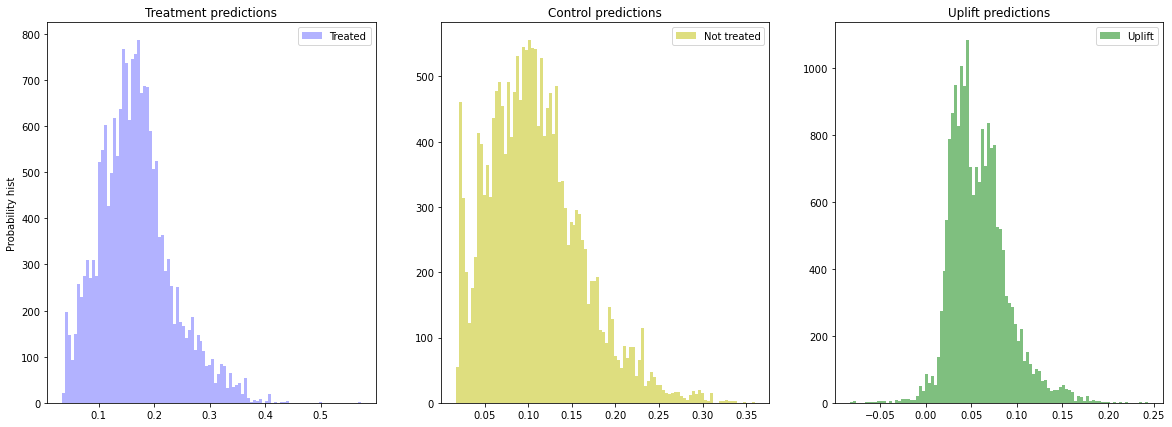

In [585]:
from sklift.metrics import uplift_at_k
from sklift.viz import plot_uplift_preds
from sklift.models import SoloModel

# sklift поддерживает любые модели, 
# которые удовлетворяют соглашениями scikit-learn
# Для примера воспользуемся catboost
from catboost import CatBoostClassifier


sm = SoloModel(CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True))
sm = sm.fit(X_train, y_train, treat_train, estimator_fit_params={'cat_features': cat_features})

uplift_sm = sm.predict(X_val)

sm_score_10 = uplift_at_k(y_true=y_val, uplift=uplift_sm, treatment=treat_val, strategy='by_group', k=0.1)
print(f'uplift@10%: {sm_score_10:.4f}')

sm_score_20 = uplift_at_k(y_true=y_val, uplift=uplift_sm, treatment=treat_val, strategy='by_group', k=0.2)
print(f'uplift@20%: {sm_score_20:.4f}')

models_results['approach'].append('SoloModel')
models_results['uplift@10%'].append(sm_score_10)
models_results['uplift@20%'].append(sm_score_20)

# Получим условные вероятности выполнения целевого действия при взаимодействии для каждого объекта
sm_trmnt_preds = sm.trmnt_preds_
# И условные вероятности выполнения целевого действия без взаимодействия для каждого объекта
sm_ctrl_preds = sm.ctrl_preds_

# Отрисуем распределения вероятностей и их разность (uplift)
plot_uplift_preds(trmnt_preds=sm_trmnt_preds, ctrl_preds=sm_ctrl_preds);

In [586]:
# С той же легкостью можно обратиться к обученной модели.
# Например, чтобы построить важность признаков:
sm_fi = pd.DataFrame({
    'feature_name': sm.estimator.feature_names_,
    'feature_score': sm.estimator.feature_importances_
}).sort_values('feature_score', ascending=False).reset_index(drop=True)

sm_fi

,feature_name,feature_score
0,treatment,18.339019
1,is_referral,17.688185
2,recency,15.700162
3,history,14.034633
4,used_discount,8.389340
5,used_bogo,8.343894
6,zip_code_Rural,5.815159
7,channel_Web,5.156292
8,channel_Phone,3.388804
9,zip_code_Surburban,1.887060


#### 5.2 Трансформация классов

In [587]:
from sklift.models import ClassTransformation


ct = ClassTransformation(CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True))
ct = ct.fit(X_train, y_train, treat_train, estimator_fit_params={'cat_features': cat_features})

uplift_ct = ct.predict(X_val)

ct_score_10 = uplift_at_k(y_true=y_val, uplift=uplift_ct, treatment=treat_val, strategy='by_group', k=0.1)
ct_score_20 = uplift_at_k(y_true=y_val, uplift=uplift_ct, treatment=treat_val, strategy='by_group', k=0.2)

models_results['approach'].append('ClassTransformation')
models_results['uplift@10%'].append(ct_score_10)
models_results['uplift@20%'].append(ct_score_20)

#### 5.3 Две независимые модели

In [588]:
from sklift.models import TwoModels


tm = TwoModels(
    estimator_trmnt=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True), 
    estimator_ctrl=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True), 
    method='vanilla'
)
tm = tm.fit(
    X_train, y_train, treat_train,
    estimator_trmnt_fit_params={'cat_features': cat_features}, 
    estimator_ctrl_fit_params={'cat_features': cat_features}
)

uplift_tm = tm.predict(X_val)

tm_score_10 = uplift_at_k(y_true=y_val, uplift=uplift_tm, treatment=treat_val, strategy='by_group', k=0.1)
tm_score_20 = uplift_at_k(y_true=y_val, uplift=uplift_tm, treatment=treat_val, strategy='by_group', k=0.2)

models_results['approach'].append('TwoModels')
models_results['uplift@10%'].append(tm_score_10)
models_results['uplift@20%'].append(tm_score_20)

plot_uplift_preds(trmnt_preds=tm.trmnt_preds_, ctrl_preds=tm.ctrl_preds_);

CatBoostError: Invalid type for cat_feature[non-default value idx=0,feature_idx=5]=nan : cat_features must be integer or string, real number values and NaN values should be converted to string.

#### 6.в конце вывести единую таблицу сравнения метрик uplift@10%, uplift@20% этих 3 моделей

In [589]:
models_results

{'approach': ['SoloModel', 'ClassTransformation'],
 'uplift@10%': [0.070959645897573, 0.07799213376985784],
 'uplift@20%': [0.07079644937850701, 0.07669259449298582]}

#### 7.построить модель UpliftTreeClassifier и попытаться описать словами полученное дерево